In [79]:
using Pkg
Pkg.clone("https://github.com/pnavaro/Splittings.jl.git")

┌ Warning: Pkg.clone is only kept for legacy CI script reasons, please use `add`
└ @ Pkg.API /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v0.7/Pkg/src/API.jl:445


  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %  Updating git-repo `https://github.com/pnavaro/Splittings.jl.git`
Fetching: [========================================>]  100.0 %.0 %

┌ Info: Path `/Users/navaro/.julia/dev/Splittings` exists and looks like the correct package, using existing path instead of cloning
└ @ Pkg.Types /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v0.7/Pkg/src/Types.jl:573


 Resolving package versions...
 Installed OrderedCollections ─ v1.0.2
 Installed DataDeps ─────────── v0.6.0
  Updating `~/.julia/environments/v0.7/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v0.7/Manifest.toml`
  [124859b0] ↑ DataDeps v0.5.2 ⇒ v0.6.0
  [bac558e1] ↑ OrderedCollections v1.0.1 ⇒ v1.0.2


In [80]:
using LinearAlgebra, QuadGK, Roots, FFTW
using Splittings

In [81]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [82]:
" Compute M₀ by solving F(m) = 0 "
function mag(β, mass)
    
    F(m) = begin
        g(x, n, m) = (1 / π) * (exp(β * m * cos(x)) * cos(n * x))
        bessel0(x) = g(x, 0, m) 
        bessel1(x) = g(x, 1, m)
        mass * quadgk(bessel1, 0, π)[1] / quadgk(bessel0, 0, π)[1] - m
    end
    
    find_zero(F, (0, mass))
end

mag

In [83]:
function Norm(f::Array{Float64,2}, dx, dv)
   return dx * sum(dv * sum(real(f), dims=1))
end

Norm (generic function with 2 methods)

In [84]:
"""
    Compute the electric hamiltonian mean field from a 
    2D distribution function
"""
function hmf_poisson!(fᵗ::Array{Float64,2}, 
        meshx::UniformMesh, 
        meshv::UniformMesh,
        ex::Array{Float64})

    nx = meshx.nx
    rho = meshv.dx .* vec(sum(fᵗ, dims=1))
    kernel = zeros(Float64, nx)
    k = π / (meshx.xmax - meshx.xmin)
    kernel[2] = k
    ex .= real(ifft(1im * fft(rho) .* kernel * 4π ))

end

hmf_poisson!

In [85]:
function bsl_advection!(meshx::UniformMesh, 
                        meshv::UniformMesh,
                        f::Array{Float64,2},
                        v::Array{Float64,1},
                        dt)
    
    @simd for j in 1:meshv.nx
        alpha = v[j] * dt
        @inbounds f[:,j] .= Splittings.interpolate(3, f[:,j], 
            meshx.dx, alpha)
    end
end

bsl_advection! (generic function with 1 method)

In [86]:
function vlasov_hmf_gauss(nbiter = 10000, deltat = 0.1)

    mass = 1.0
    T = 0.1
    meshx = UniformMesh(-π, π, 64)
    meshv = UniformMesh(-8, 8, 64)
    
    nx, dx = meshx.nx, meshx.dx
    nv, dv = meshv.nx, meshv.dx
    x, v = meshx.x, meshv.x
    X = repeat(x,1,nv)
    V = repeat(v,1,nx)'
    ϵ = 0.1
    
    b = 1 / T
    m = mag(b, mass)
   
    w   = sqrt(m)
    f   = zeros(Float64, (nx,nv))
    fᵗ  = zeros(Float64, (nv,nx))
    
    f  .= exp.(-b .* ((V.^2 / 2) - m * cos.(X)))
    a   = mass / Norm(f, dx, dv)
    @.  f =  a * exp(-b * (((V^2) / 2) - m * cos(X))) * (1 + ϵ * cos(X))
    
    ex = zeros(Float64,nx)
    hmf_poisson!(f, meshx, meshv, ex )
    test = copy(f)
    T = Float64[]
    for n in 1:nbiter
    
        gamma1 = Norm(f .* cos.(X), dx, dv)
        push!(T,gamma1)
    
        """Vlasov-HMF Strang"""
        bsl_advection!(meshx, meshv, f, v, deltat / 2)
        transpose!(fᵗ, f)
        hmf_poisson!(fᵗ, meshx, meshv, ex)
        bsl_advection!(meshv, meshx, fᵗ, ex, deltat)
        transpose!(f, fᵗ)
        bsl_advection!(meshx, meshv, f, v, deltat / 2)
    
    end
    
    #Substracting from gamma its long time average
    
    Gamma1 = Norm(f .*cos.(X), dx, dv)
    T .= T .- Gamma1
    
    range(0., stop=nbiter*deltat, length=nbiter), abs.(T)
    
end 

vlasov_hmf_gauss (generic function with 3 methods)

In [87]:
nbiter = 10000
deltat = 0.1
@time t, T = vlasov_hmf_gauss(nbiter, deltat);

 88.349981 seconds (248.93 M allocations: 29.940 GiB, 7.59% gc time)


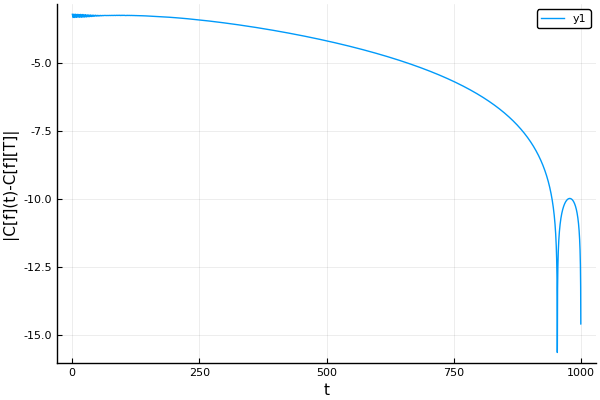

In [88]:
plot(t, log.(T), 
    xlabel = "t",
    ylabel = "|C[f](t)-C[f][T]|")